## Background
Operators offer capping products which limit the amount their customers are charged over a certain period (e.g. daily or weekly). For example:

For a daily capping limit of 5 dollars:

| Day | Amount | Adjusted Amount | Accumulated for the day |
|:----|:-------|:-|:-|
| Trip 1 day 1 | 2 | 2 | 2 |
| Trip 2 day 1 | 2 | 2| 4 | 
| Trip 3 day 1| 2 | 1 | 5 | 
| Trip 1 day 2 | 3 | 3 | 3 | 
| Trip 2 day 2 | 3 | 2 | 5 | 
| Trip 3 day 2 | 3 | 0 | 5 | 

 
## Given:
Given the data dictionary below

#### Products
This table contains the capping product definitions

| Field                              | Description |
|:-----------------------------------|:--|
| id                                 | Unique ID |  
| product_type                       | CAPPING |  
| capping_type                       | DAILY or WEEKLY |  
| created_date                       | Date created |  
| start_date_utc                     | Effective start date |  
| status                             | ACTIVE or INACTIVE |  
| rules_default_limit                | Capping limit amount |  
| rules_max_fare_value               | Fare above this are not included in the capping |  
| rules_transaction_types            | Type of fare |  
| rules_from_time_local              | Time of day in which capping starts effectivity |  
| rules_to_time_local                | Time of day in which capping ends effectivity |  
| rules_weekly_cap_start_day         | If weekly capping, this is the start day (e.g. SUNDAY, MONDAY) |  
| rules_capping_duration_in_minutes  | If product_type is time based, free transfer window |  
| rules_number_of_transfer           | If product_type is time based, number of free transfer |  

#### Trips
This table contains the trips

| Field                       | Description | 
|:----------------------------|:--|
| charge_id                   | Unique Id of the associated charge |  
| trip_id                     | Unique Id of this trip | 
| tap_on_id                   | Tap ON ID provided | 
| tap_on_date                 | Date tapped on |  
| tap_off_id                  | Tap OFF ID provided (if variable) |  
| tap_off_date                | Date tapped off for variable fare |  
| original_amount             | Actual fare |  
| adjusted_amount             | Adjustment after capping was applied |  
| service_type                |  |  
| direction                   |  |  
| fare_type                   | flat, variable or retail|  
| trip_completion             | If trip was completed (if variable and no tap off, this is incomplete) |  

#### Adjustments
This table contains all the adjustments (including zero amount) that were done for a trip. An entry here means the a trip was qualified for a product.

| Field             | Description |
|:------------------|:--|
| product_id        | ID from the product table |  
| trip_id           | Trip ID from the trips table |  
| adjustment_id     | ID related to the group of adjustments. i.e.  |  
| adjustment_amount | Amount deducted from the actual fare |  
| adjustment_type   | Capping type from product table |  
| applied           | True if the fare was adjusted |  
| zone_ids_used     | Zones used in the adjustment |  

For the example earlier, it would have the following sample entries:

##### Product

| id | capping_type | rules_default_limit |
|:- |:-|:-|
| P1| DAILY | 5.0 |
| P2| WEEKLY | 40.0 |

##### Trip

| trip_id | tap_on_date | original_amount | adjusted_amount | trip_completion |
|:-|:-|:-|:-|:-|
| T1 | 2021-07-20 13:00:00.000 | 2.0  | 2.0  | complete  |
| T2 | 2021-07-20 14:00:00.000 | 2.0  | 2.0  | complete  |
| T3 | 2021-07-20 15:00:00.000 | 2.0  | 1.0  | complete  |
| T4 | 2021-07-21 13:00:00.000 | 3.0  | 3.0  | complete  |
| T5 | 2021-07-21 14:00:00.000 | 3.0  | 2.0  | complete  |
| T6 | 2021-07-21 15:00:00.000 | 3.0  | 0.0  | complete  |

###### Adjustments

| product_id| trip_id | adjustment_id | adjustment_amount | applied |
|:-|:-|:-|:-|:-|
| P1 | T1 | AJ1 | 0.0 | false |
| P1 | T2 | AJ1 | 0.0 | false |
| P1 | T3 | AJ1 | 1.0 | true  |
| P1 | T4 | AJ2 | 0.0 | false |
| P1 | T5 | AJ2 | 1.0 | true  |
| P1 | T6 | AJ2 | 3.0 | true  |
| P2 | T1 | AJ3 | 0.0 | false |
| P2 | T2 | AJ3 | 0.0 | false |
| P2 | T3 | AJ3 | 0.0 | false |
| P2 | T4 | AJ4 | 0.0 | false |
| P2 | T5 | AJ4 | 0.0 | false |
| P2 | T6 | AJ4 | 0.0 | false |


## Problem

1. Visualise the growth of the transactions volume (number) and amount which shows before and after the product was applied
2. (Optional) Provide insights about the visualisation. Were the capping product effective? If so, how effective? etc

### Note
You can use any library you like. Just declare it.

In [13]:
# Imports
# NB. You dont have to use pandas.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_columns', None)

In [2]:
products_df = pd.read_csv('products.csv', sep=',')
trips_df = pd.read_csv('trips.csv', sep=',')
adjustments_df = pd.read_csv('adjustments.csv', sep=',')

In [3]:
#Join trips and adjustments
trips_with_adjustments = trips_df.join(adjustments_df.set_index('trip_id'), on = ['trip_id'], how = 'left', lsuffix='trip_', rsuffix='adj_')

<h2>Capping product applied date</h2>

In [83]:
# Since all the capping products were applied on a single day, we will get the first date
date_capping_applied = products_df.created_date.apply(lambda s: s.split('T')[0])[0]

print(f"Date capping applied = {date_capping_applied}")

Date capping applied = 2019-07-17


In [89]:
volume_growth = trips_with_adjustments[['tap_on_date']].copy()


# Convert the date column to datetime format
volume_growth['date'] = pd.to_datetime(volume_growth['tap_on_date'])

applied_dt = datetime.strptime(date_capping_applied, "%Y-%m-%d")


<h2>Trips volume growth weekly before capping product</h2>

<Axes: xlabel='date'>

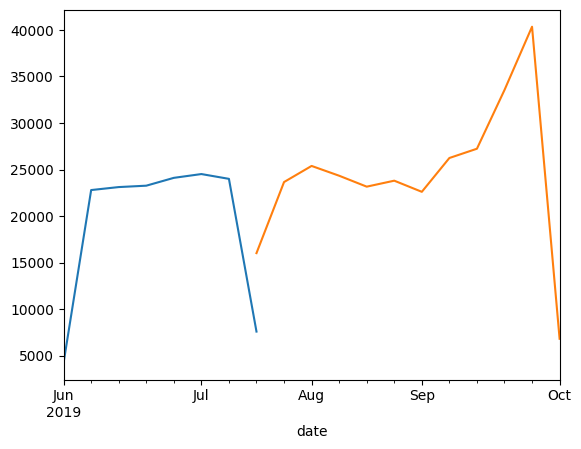

In [100]:
before_capping_growth = volume_growth[volume_growth.date < applied_dt]

# Set the index to the date column, filter data before capping
before_capping_growth.set_index('date', inplace=True)

# Group the data by week, as we see a big drop on weekends
before_capping_growth.resample('W-SUN').size().plot()

after_capping_growth = volume_growth[volume_growth.date >= applied_dt]

# Set the index to the date column, filter data before capping
after_capping_growth.set_index('date', inplace=True)

# Group the data by week, as we see a big drop on weekends
after_capping_growth.resample('W-SUN').size().plot()

<h2>Trips volume growth weekly after capping product</h2>

In [43]:
trips_with_adjustments.columns

Index(['customer_id', 'charge_id', 'trip_id', 'tap_on_id', 'tap_on_date',
       'tap_off_id', 'tap_off_date', 'original_amount', 'adjusted_amount',
       'service_type', 'direction', 'fare_type', 'trip_completion',
       'product_id', 'adjustment_id', 'adjustment_amount', 'adjustment_type',
       'applied', 'zone_ids_used', 'trip_date'],
      dtype='object')

<h2>Operator fare collections growth weekly plot</h2>

<Axes: xlabel='date'>

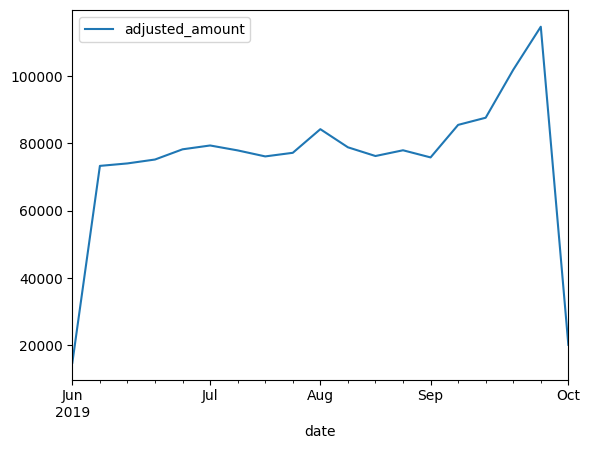

In [49]:
amount_growth = trips_with_adjustments[['tap_on_date', 'adjusted_amount']].copy()


# Convert the date column to datetime format
amount_growth['date'] = pd.to_datetime(amount_growth['tap_on_date'])

# Set the index to the date column
amount_growth.set_index('date', inplace=True)

# Group the data by week, as we see a big drop on weekends
amount_growth = amount_growth.resample('W-SUN').sum()

amount_growth.plot()

Calculate saving for customers from the product

In [71]:

totalSavings = (trips_with_adjustments.original_amount - trips_with_adjustments.adjusted_amount).sum()

uniqueCustomersCount = trips_with_adjustments[trips_with_adjustments['adjustment_id'].notna()].customer_id.unique().size

print(f"Savings of {totalSavings} for {uniqueCustomersCount} unique customers")



Savings of 3671.0800000000013 for 11993 unique customers


Questions
1. Daily volume growth.
2. Daily volume growth before and after a product was applied.
3. Daily amount growth.
4. Daily amount growth before and after a product was applied.
5. Effectiveness of capping
6. 